# BIN 11 center failure Fab B PCM vs FT Failure Rate Analysis



**OVERVIEW**

In Semiconductor foundry engineering, we need to do fab transfer time to time to resolve any potential capacity issues.  That means we need to transfer a running process in Fab A  to Fab B and ensure the performance matches between the two fabs.

WAT (wafer acceptance test) is a wafer level parametric test using scribe line test kits to check the wafer circuit performance.

After wafers finish WAT and fab process, they are moved to assembly and Final test.   The final product’s performance can be measured by Final test data with ATE test equipment.

In the fab transfer from Fab A to Fab B, the ultimate goal is to make sure the Final test data yield are comparable.

In a Fab transfer project we have, we found out Fab B shows ~0.7% higher yield loss than Fab A. 

So it is critical to find out what could cause the yield delta and improve the yield in Fab B by process tuning.  WAT is a key to find out the wafer process related parameters.  So a FT vs WAT correlation and feature findings are needed for debug.



In [6]:
import numpy as np
import pandas as pd



In [7]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

### Data Understanding

PCM (process control monitor) parameter data understanding with info (), describe().  Check null values.
From the data cleaning, data are a mix of objects and numerical data, and data contains NaN


In [9]:
## load data to a dataframe to check the data inforamtion
## check the columns and datatype with info()
## check statistics with describe()
## check what the data look like by using head()
pcm=pd.read_csv('data/Austin-PCM.csv')
print(pcm.info())
print(pcm.describe())
print(pcm.isnull().sum())
pcm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Columns: 123 entries, Fab to Vtl_P4OD
dtypes: float64(107), int64(10), object(6)
memory usage: 238.4+ KB
None
         Fab  Wafer Number        PCMx        PCMy           1          11  \
count  248.0    248.000000  248.000000  248.000000  248.000000  248.000000   
mean     0.0     14.528226   -0.427419   -0.161290    0.952006    0.001187   
std      0.0      2.872318    1.795962    2.321828    0.169091    0.010622   
min      0.0     10.000000   -3.000000   -4.000000    0.000000    0.000000   
25%      0.0     12.000000   -2.000000   -2.000000    0.980952    0.000000   
50%      0.0     15.000000    0.000000    0.000000    0.990476    0.000000   
75%      0.0     17.000000    1.000000    2.000000    0.995238    0.000000   
max      0.0     19.000000    3.000000    4.000000    1.000000    0.156250   

               12          13          16          18  ...     Vtl_N45  \
count  248.000000  248.000000  248.000000

,Fab,Source Lot,Wafer,Wafer Number,PCMx,PCMy,1,11,12,13,...,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4L,Vtl_P4OD
0,0,N9TK60.S,N9TK60_14,14,-3,-3,0.919048,0.0,0.0,0.009524,...,0.735,0.300781,0.640,1.832,0.815,-0.619,-0.872,-0.767,NaN,-0.593
1,0,N9TK60.S,N9TK60_14,14,-3,-1,0.976190,0.0,0.0,0.009524,...,0.746,0.298340,0.626,1.834,0.816,-0.608,-0.862,-0.762,NaN,-0.589
2,0,N9TK60.S,N9TK60_14,14,-3,1,0.985714,0.0,0.0,0.014286,...,0.731,0.300781,0.616,1.834,0.820,-0.606,-0.868,-0.763,NaN,-0.578
3,0,N9TK60.S,N9TK60_14,14,-3,3,0.964286,0.0,0.0,0.000000,...,0.750,0.305664,0.628,1.833,0.817,-0.618,-0.869,-0.769,NaN,-0.591
4,0,N9TK60.S,N9TK60_14,14,-2,-4,0.993750,0.0,0.0,0.006250,...,0.739,0.300781,0.630,1.828,0.810,-0.623,-0.862,-0.772,NaN,-0.593


### Data Preparation

Clean up the data and remove null values. 

In [10]:
## Data cleaning by dropping all NaN data
pcm = pcm.dropna(axis=1)
print(pcm.isnull().sum()) # check to see if any null values in any columns.
pcm.isnull().sum().to_csv('data/null_summary.csv')
pcm.to_csv('data/Austin-PCM-clean.csv')
## Drop wafer (it is duplicating with wafer number)
pcm = pcm.drop('Wafer',axis =1)
pcm.head()

Fab             0
Source Lot      0
Wafer           0
Wafer Number    0
PCMx            0
               ..
Vtl_NNGD        0
Vtl_P4          0
Vtl_P45         0
Vtl_P45L        0
Vtl_P4OD        0
Length: 121, dtype: int64


,Fab,Source Lot,Wafer Number,PCMx,PCMy,1,11,12,13,16,...,Vtl_N44,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4OD
0,0,N9TK60.S,14,-3,-3,0.919048,0.0,0.0,0.009524,0.0,...,0.570,0.735,0.300781,0.640,1.832,0.815,-0.619,-0.872,-0.767,-0.593
1,0,N9TK60.S,14,-3,-1,0.976190,0.0,0.0,0.009524,0.0,...,0.587,0.746,0.298340,0.626,1.834,0.816,-0.608,-0.862,-0.762,-0.589
2,0,N9TK60.S,14,-3,1,0.985714,0.0,0.0,0.014286,0.0,...,0.590,0.731,0.300781,0.616,1.834,0.820,-0.606,-0.868,-0.763,-0.578
3,0,N9TK60.S,14,-3,3,0.964286,0.0,0.0,0.000000,0.0,...,0.581,0.750,0.305664,0.628,1.833,0.817,-0.618,-0.869,-0.769,-0.591
4,0,N9TK60.S,14,-2,-4,0.993750,0.0,0.0,0.006250,0.0,...,0.578,0.739,0.300781,0.630,1.828,0.810,-0.623,-0.862,-0.772,-0.593


In [11]:
# use nunique() function to check all object columns to see how many unique categories for each column
# Check how many states in the data by using unique() function.  
print(pcm.info())
print(pcm[make_column_selector(dtype_include='object')].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Columns: 120 entries, Fab to Vtl_P4OD
dtypes: float64(105), int64(10), object(5)
memory usage: 232.6+ KB
None
Source Lot     1
Lot            1
Wafer ID      10
Lot ID         1
Part ID        1
dtype: int64


In [12]:
# Drop wafer ID, lot ID and Part ID
print(pcm.columns)
pcm = pcm.drop(columns=['Wafer ID','Lot ID','Part ID','PCMx','PCMy'])
pcm = pcm.drop(columns =['1','11','12','16','18','19','22','23','26','27','28','29','30','42','43','44','8','9','99','13'])
pcm = pcm.drop(columns=['Source Lot','Wafer Number','Count()','Lot'])
#print(pcm['Source Lot'].unique())

Index(['Fab', 'Source Lot', 'Wafer Number', 'PCMx', 'PCMy', '1', '11', '12',
       '13', '16',
       ...
       'Vtl_N44', 'Vtl_N45', 'Vtl_N4N', 'Vtl_N4OD', 'Vtl_NFGD', 'Vtl_NNGD',
       'Vtl_P4', 'Vtl_P45', 'Vtl_P45L', 'Vtl_P4OD'],
      dtype='object', length=120)


In [13]:
## Check pcm data again to see which column is object
print(pcm[make_column_selector(dtype_include='object')].nunique())

Series([], dtype: float64)


In [14]:
## Use make_column_transformer to convert all objects using OneHotEncoder, then standardize the numerical data with standardscaler

col_transformer= make_column_transformer((StandardScaler(),make_column_selector(dtype_include='number')))

## Use fit_transform to transform the car dataframe
pcm_transformed=col_transformer.fit_transform(pcm)

## Get numerical column names out by using get_feature_names_out()
## col_transformer.transformers_[0]:This accesses the first tuple in the transformers_ list of the col_transformer object.
##col_transformer.transformers_[0][1]:  This access the second element of the first tuples, which is the StandardScaler

num_features=col_transformer.transformers_[0][1].get_feature_names_out()
## Convert back to dataframe
transformed_pcm = pd.DataFrame(pcm_transformed, columns=num_features)
#transformed_pcm = transformed_pcm.dropna()

## prepare the feature dataset as X_pcm and the yield as y_pcm
X_pcm = transformed_pcm.drop('VPOR_UPPER_yield',axis =1)
y_pcm = transformed_pcm['VPOR_UPPER_yield']
X_pcm.head()


,Fab,Site ID,BV_N4,BV_N44,BV_N45,BV_N45SA,BV_N46SA,BV_N4OD,BV_N5A6CB,BV_N5A6SB,...,Vtl_N44,Vtl_N45,Vtl_N4N,Vtl_N4OD,Vtl_NFGD,Vtl_NNGD,Vtl_P4,Vtl_P45,Vtl_P45L,Vtl_P4OD
0,0.0,-1.226045,-0.003448,0.015987,-0.103259,0.096411,-1.016261,-0.042648,0.271758,0.033058,...,-0.188101,-0.155017,-0.045832,0.070344,-0.080012,-0.371019,-0.156947,0.084580,0.125057,-0.083271
1,0.0,-1.354612,-0.003448,0.015987,-0.103259,0.096411,-1.016261,-0.042648,-0.388986,0.033058,...,-0.077820,-0.078338,-0.068428,-0.116952,-0.032879,-0.179326,0.033174,0.158726,0.170692,-0.032059
2,0.0,-1.483178,-0.003448,0.015987,-0.103259,-0.195174,0.983999,0.100280,0.271758,0.033058,...,-0.058358,-0.182900,-0.045832,-0.250734,-0.032879,0.587448,0.067741,0.114239,0.161565,0.108773
3,0.0,-1.611744,0.139082,0.015987,-0.103259,-0.195174,-1.016261,0.100280,-0.388986,0.033058,...,-0.116743,-0.050454,-0.000637,-0.090195,-0.056446,0.012367,-0.139664,0.106824,0.106802,-0.057665
4,0.0,-1.097479,-0.003448,0.015987,-0.103259,-0.195174,-1.016261,-0.042648,-0.388986,0.033058,...,-0.136204,-0.127134,-0.045832,-0.063439,-0.174278,-1.329486,-0.226082,0.158726,0.079421,-0.083271


### Modeling

Ridge Model and Lasso Model with GridSearchCV and Pipleline+ PCA

In [15]:
## Split the cleaned X_car and y_car with train_test_split
X_train, X_test,y_train,y_test = train_test_split(X_pcm,y_pcm, test_size = 0.2, random_state =42)


In [16]:
# Build a pipeline with PCA to reduce the features to 5
# Use Ridge model with default alpha value

train_preds_1 =''
test_preds_1 =''
train_mse_1=''
test_mse_1=''
ridge_grid=''

pipe = Pipeline([('pca',PCA(n_components=5)),('model', Ridge())])
pipe.fit(X_train,y_train)
train_preds_1 =pipe.predict(X_train)
test_preds_1 = pipe.predict(X_test)
train_mse_1 = mean_squared_error(train_preds_1,y_train)
test_mse_1 = mean_squared_error(test_preds_1,y_test)
print(f'Ridge Train MSE alpha=1: {train_mse_1}')
print(f'Ridge Test MSE alpha=1: {test_mse_1}')

## To see the explained variance ratio of each principal component
explained_variance = pipe.named_steps['pca'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Determine the number of components needed to reach 80% variance. 
# If the cumulative explained variance with PCA =5 is less than 80%, then the num_components will return 1.
num_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print("Number of components to reach 80% variance:", num_components)
pipe

print("################################################################################")
## Add in GridSearchCV to check the best Alpha for Ridge model with Apha from 0-4 with 5 steps
ridge_para_dict=''
ridge_pipe=''
ridge_train_mse=''
ridge_test_mse=''

ridge_param_dict = {'model_s__alpha': np.linspace(0, 2000, 10)}
ridge_pipe = Pipeline([('pca_s',PCA(n_components=5)),('model_s', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe,param_grid = ridge_param_dict)
ridge_grid.fit(X_train,y_train)
ridge_train_preds=ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(ridge_train_preds,y_train)
ridge_test_mse = mean_squared_error(ridge_test_preds,y_test)
print(f'Train MSE with Gridsearch: {ridge_train_mse}')
print(f'Test MSE with Gridsearch: {ridge_test_mse}')
## To see the explained variance ratio of each principal component
explained_variance = pipe.named_steps['pca'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## Find the best alpha
best_alpha=ridge_grid.best_params_['model_s__alpha']
print("best alpha value",best_alpha)


## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)


Ridge Train MSE alpha=1: 1.211963270374064
Ridge Test MSE alpha=1: 0.07230191487360094
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917]
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317]
Number of components to reach 80% variance: 1
################################################################################
Train MSE with Gridsearch: 1.2183192692868403
Test MSE with Gridsearch: 0.04657541516435319
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917]
best alpha value 666.6666666666667
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317]


In [17]:
# Build a pipeline with PCA to reduce the features to 5 and Lasso regression
# Use Lasso model 
train_preds_2 =''
test_preds_2 =''
train_mse_2=''
test_mse_2=''
pipe = Pipeline([('pca',PCA(n_components=5)),('model', Lasso())])
pipe.fit(X_train,y_train)
train_preds_2 =pipe.predict(X_train)
test_preds_2 = pipe.predict(X_test)
train_mse_2 = mean_squared_error(train_preds_2,y_train)
test_mse_2 = mean_squared_error(test_preds_2, y_test)
print(f'lasso Train MSE: {train_mse_2}')
print(f'lasso Test MSE: {test_mse_2}')
pipe

lasso Train MSE: 1.2461000258683739
lasso Test MSE: 0.03186912421811693


Pipeline(steps=[('pca', PCA(n_components=5)), ('model', Lasso())])

### Optimize Models

With some simple Ridge and Lasso model completed, try to optimize the Ridge model with the following steps:
1. Build a Pipeline with PCA and Ridge model
2. Optimize the Ridge model with hyper parameter of Alpha and PCA components to achieve > 95% of explained varaiance.

Train MSE with Gridsearch: 1.2179761244535807
Test MSE with Gridsearch: 0.02721533245357877
explained variance ratio of the PCA components:[0.4989667  0.14183691 0.07027911 0.04718128 0.03443917 0.03119678
 0.0214938  0.01779297 0.01472297 0.01237328 0.01202568 0.01076626
 0.01036021 0.0092242  0.00849651 0.0073644  0.00670744 0.00585097
 0.00478256 0.00437512]
best alpha value 2000.0
Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317 0.82389995
 0.84539375 0.86318672 0.8779097  0.89028298 0.90230866 0.91307492
 0.92343513 0.93265932 0.94115583 0.94852023 0.95522767 0.96107864
 0.9658612  0.97023632]
Number of components to reach 95% variance: 17


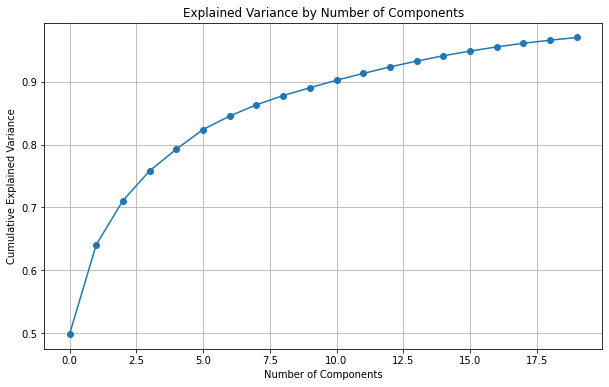

 
 Top 10 features which impact BIN11 failures:
        Feature  Coefficient
71  Rs_PODRPO2     0.012936
53   Iof_PTM9A    -0.010889
16   Cmim40X50     0.010483
58      Rc_TV1    -0.010032
65  Rs_NODRPO2     0.009208
61      Rs_HRI     0.008754
49     Iof_P45    -0.008469
67   Rs_NW_STI     0.008355
66  Rs_NPORPO2     0.008239
72  Rs_PPORPO2     0.007339


In [18]:
## Build a Pipeline to optimize Ridge model hyperparameters and PCA components in the ridge_param_dict to optimize alpha, Solver
## fit intercept and pca components

ridge_para_dict=''
ridge_pipe=''
ridge_train_mse=''
ridge_test_mse=''

# Define the parameter grid
ridge_param_dict = {
    'model_s__alpha': np.linspace(0, 2000, 10),
    'model_s__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88]
}
ridge_pipe = Pipeline([('pca_s',PCA()),('model_s', Ridge())])

# Initialize GridSearchCV
ridge_grid = GridSearchCV(ridge_pipe,param_grid = ridge_param_dict,cv=5)
ridge_grid.fit(X_train,y_train)

# Retrieve the best model
best_model = ridge_grid.best_estimator_


# Predictions and MSE
ridge_train_preds=best_model.predict(X_train)
ridge_test_preds =best_model.predict(X_test)
ridge_train_mse = mean_squared_error(ridge_train_preds,y_train)
ridge_test_mse = mean_squared_error(ridge_test_preds,y_test)
print(f'Train MSE with Gridsearch: {ridge_train_mse}')
print(f'Test MSE with Gridsearch: {ridge_test_mse}')

## To see the explained variance ratio of each principal component
explained_variance = ridge_grid.best_estimator_.named_steps['pca_s'].explained_variance_ratio_
print(f"explained variance ratio of the PCA components:{explained_variance}")

## Find the best alpha
best_alpha=ridge_grid.best_params_['model_s__alpha']
print("best alpha value",best_alpha)

## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to reach 80% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print("Cumulative Explained Variance:", cumulative_explained_variance)
print("Number of components to reach 95% variance:", num_components)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

# Ridge coefficients for principal components
ridge_coefs_pcs = ridge_grid.best_estimator_.named_steps['model_s'].coef_
components_sim = ridge_grid.best_estimator_.named_steps['pca_s'].components_

#print("ridge coef:",ridge_coefs_pcs)
ridge_coefs_pcs_df = pd.DataFrame({'ridge_coef_PC':ridge_coefs_pcs})
#print (ridge_coefs_pcs_df.head())

# Transform back to original feature space
original_feature_coefs = np.dot(components_sim.T, ridge_coefs_pcs)
# Create a DataFrame for easier interpretation
feature_names=X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': original_feature_coefs})
#print("Original Coefficient dataframe:\n")
#print(coef_df)

# Sort the DataFrame by the absolute value of the coefficients for top 10 most inflential factors
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
print(" \n Top 10 features which impact BIN11 failures:\n",df_top_features[['Feature', 'Coefficient']])


In [19]:
## Check best model parameters
print(ridge_grid.best_params_)

{'model_s__alpha': 2000.0, 'model_s__fit_intercept': False, 'model_s__solver': 'sparse_cg', 'pca_s__n_components': 20}


In [20]:
# Optimize Lasso model

Lasso_para_dict=''
Lasso_pipe=''
Lasso_train_mse=''
Lasso_test_mse=''
# Define the parameter grid
lasso_param_dict = {
    'model_s__alpha': np.linspace(0.001, 0.1, 10),
    'model_s__selection': ['cyclic','random'],
    'model_s__fit_intercept': [True, False],
    'pca_s__n_components': [12, 20, 25, 60, 70, 80, 88]
}

# Define the pipeline
lasso_pipe = Pipeline([
    ('pca_s', PCA()),
    ('model_s', Lasso())
])

# Perform grid search cross-validation
grid_search = GridSearchCV(lasso_pipe, lasso_param_dict, cv=5)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_lasso_model = grid_search.best_estimator_

# Fit the best model on the training data
best_lasso_model.fit(X_train, y_train)
# Make predictions
lasso_train_preds = best_lasso_model.predict(X_train)
lasso_test_preds = best_lasso_model.predict(X_test)

# Make predictions
lasso_train_preds = best_lasso_model.predict(X_train)
lasso_test_preds = best_lasso_model.predict(X_test)

# Calculate MSE
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)

print(f"Training MSE: {lasso_train_mse}")
print(f"Test MSE: {lasso_test_mse}")

Training MSE: 1.204239571351269
Test MSE: 0.04366562406726857


Cumulative Explained Variance: [0.4989667  0.64080361 0.71108272 0.758264   0.79270317 0.82389995
 0.84539375 0.86318672 0.8779097  0.89028298 0.90230866 0.91307492
 0.92343513 0.93265932 0.94115583 0.94852023 0.95522767 0.96107864
 0.9658612  0.97023632]
Number of components to reach 95% variance: 17


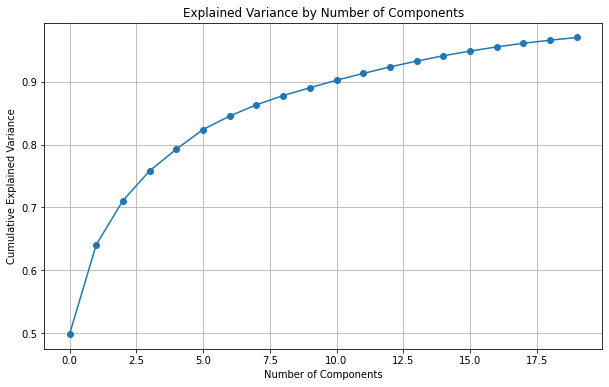

In [21]:
## calculate cumulative explained varaince ratio
cumulative_explained_variance = np.cumsum(explained_variance)

# Determine the number of components needed to reach 80% variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print("Cumulative Explained Variance:", cumulative_explained_variance)
print("Number of components to reach 95% variance:", num_components)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [23]:
# Lasso coefficients for principal components
lasso_coefs_pcs = grid_search.best_estimator_.named_steps['model_s'].coef_
components_sim = grid_search.best_estimator_.named_steps['pca_s'].components_

lasso_coefs_pcs_df = pd.DataFrame({'lasso_coef_PC':lasso_coefs_pcs})
#print lasso_coefs_pcs_df.head())

# Transform back to original feature space
original_feature_coefs = np.dot(components_sim.T, lasso_coefs_pcs)
# Create a DataFrame for easier interpretation
feature_names=X_train.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': original_feature_coefs})
print("Original Coefficient dataframe:\n")
print(coef_df)


# Sort the DataFrame by the absolute value of the coefficients for top 10 most inflential factors
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
df_top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False).head(10)
print(" \n Top 10 features which impact BIN11 failures:\n",df_top_features[['Feature', 'Coefficient']])

Original Coefficient dataframe:

     Feature   Coefficient
0        Fab  5.433810e-19
1    Site ID  6.334109e-03
2      BV_N4  1.105952e-03
3     BV_N44  3.070227e-04
4     BV_N45  1.818315e-03
..       ...           ...
85  Vtl_NNGD -5.924119e-03
86    Vtl_P4 -3.992515e-04
87   Vtl_P45 -1.245098e-03
88  Vtl_P45L -1.067226e-03
89  Vtl_P4OD -5.868073e-04

[90 rows x 2 columns]
 
 Top 10 features which impact BIN11 failures:
        Feature  Coefficient
61      Rs_HRI     0.022375
71  Rs_PODRPO2     0.020197
16   Cmim40X50     0.019557
53   Iof_PTM9A    -0.019451
72  Rs_PPORPO2     0.018970
50    Iof_P45L    -0.017601
65  Rs_NODRPO2     0.016797
66  Rs_NPORPO2     0.016650
62  Rs_HRIserp     0.013830
67   Rs_NW_STI     0.013069


### Top 10 WAT impacting BIN11 from Ridge and Lasso

With >95% explained variance simulation, the top 10 features which impact the FT Bin11 are as followings.  First table is Lasso and the second table is Ridge

| Feature | Coefficient |
|----------|----------|
|  Rs_HRI   |  0.022375|
|Rs_PODRPO2  |   0.020197 |
|Cmim40X50  |   0.019557 |
|Iof_PTM9A |   -0.019451|
|Rs_PPORPO2  |   0.018970|
| Iof_P45L |   -0.017601 |
|Rs_NODRPO2  |   0.016797 |
| Rs_NPORPO2   |  0.016650 |
| Rs_HRIserp |    0.013830 |
| Rs_NW_STI  |   0.013069 |

| Feature | Coefficient|
|----------|----------|
| Rs_PODRPO2  |   0.012936|
| Iof_PTM9A |   -0.010889 |
| Cmim40X50 |    0.010483 |
|  Rc_TV1   |  -0.010032  |
| Rs_NODRPO2 |    0.009208 |
| Rs_HRI   |  0.008754   |
| Iof_P45  |  -0.008469|
| Rs_NW_STI |    0.008355 |
| Rs_NPORPO2 |    0.008239 |
| Rs_PPORPO2 |    0.007339|


In this analysis, I used PCA to reduce the component for easy analysis.  The PCA analysis ensures the components can represent 95% of the original data information.  Pipeline, lasso and ridge model with GridSearchCV are used for regression and optimized for hyperparameters for Ridge and Lasso model.  Compared the MSE to identify Ridge model is better than Lasso model.  Identified the top 10 features which influence the Bin11 failure the most. Lasso model top 10 features match with Ridge Model top 10 well (the sequences are different and only 2 parameters are different).  I think the WAT parameters are highly correlated with each others.  So it is better to use Ridge model.

Hold out validation of the test MSE shows Lasso = 0.043 and Ridge = 0.027

Futher debug reveals that FT pass / fail yield and bin failure rate might not be the best way to debug this issue, because the FT test instability was found due to ringing issues.
Final test (FT) was changed from pass / fail to POR circuit trip point parametric data collection.
Based on the new trip point data, redo the analysis using random forest regression and Ridge model with GridSearchCV + feature permutation to find the most relevant WAT parameters.